# 論文の再現性を確認 by めろ

[元の論文 Inoue, D., Okada, A., Matsumori, T. et al. Traffic signal optimization on a square lattice with quantum annealing. Sci Rep 11, 3303 (2021)](https://www.nature.com/articles/s41598-021-82740-0)

## assumptions

consider a squared map with $L\times L$ intersections, $\sigma_i$ represents $i$th intersection's traffic signal (north-south=1, west-east=-1)

number of vehicles from $i$th intersection to $i$th is
$$q_{ij}(t) = q_{ij}(t-1) + \frac{s_{ij}}{2} (-\sigma_i + \alpha \sigma_j)$$
flow bias is
$$x(t) = x(t-1) + (-I + \frac{\alpha}{4}A) \sigma(t-1)$$

## cost function (Ising model)

the cost function (Ising model) is defined as 
$$H(\sigma(t)) = \sigma(t)^T J \sigma(t) + h \sigma(t) + c(t)$$
where
$$J = (-I + \frac{\alpha}{4}A)^T(-I + \frac{\alpha}{4}A) + \eta I$$
$$h = 2x(t)^T (-I + \frac{\alpha}{4}A) - 2 \eta \sigma(t-1)^T$$

initial conditions
- $x(t=0)$ is generated as random numbers in uniform distribution within the range [-5.0, 5.0]
- $\sigma(t=0)$ is generated as random numbers either +1 or -1

dimsions confirmation
- signal vector $\sigma(t) = L^2 \times 1$
- flow bias $x(t) = L^2 \times 1$
- identity matrix $I = L^2 \times L^2$
- periodic lattice matrix $A = L^2 \times L^2$
- $J = L^2 \times L^2$
- $h = 1 \times L^2$

## implementations

### matrix generator

In [1]:
import numpy as np

def A_maker(L):
    A = np.zeros(L**4).reshape(L**2, L**2)
    
    for i in range(L):
        for j in range(L):
            """
            # every intersection has four neighborhoods
            """            
            four_dirc = []
            four_dirc.append( (i - 1) * L + j ) # north
            four_dirc.append( (i + 1) * L + j ) # south
            four_dirc.append( i * L + (j - 1) ) # west
            four_dirc.append( i * L + (j + 1) ) # east
            
            for neighbor in four_dirc:
                """
                # but does not count the neighbor who is out of the lattice range
                """
                if neighbor>=0 and neighbor<L**2:
                    A[i*L+j][neighbor] = 1
    
    return A

### params

In [2]:
# hyper-parameters
L = 50
alpha = 0.8
eta = 1.0

theta = eta # local control threshold

In [3]:
# const matrix
import numpy as np
I = np.identity(L**2)
A = A_maker(L = L)           

In [4]:
# J is also constant
J = np.dot((- I + alpha/4*A).T, (- I + alpha/4*A)) + eta*I
Jdict = {}
for i in range(J.shape[0]):
    for j in range(J.shape[1]):
        if i>j:
            Jdict[(i,j)] = J[i][j] * 2            

## QA ising

In [5]:
import openjij as oj
sampler = oj.SASampler(num_reads = 5)

In [6]:
# initial values
x_qa = np.random.uniform(low=-5.0, high=5.0, size=L**2).reshape(L**2, 1)
x_local = np.random.uniform(low=-5.0, high=5.0, size=L**2).reshape(L**2, 1)

import random
sigma_list = [-1, 1]

# sigma for QA analysis
sigma_qa = random.choices(sigma_list, k = L**2)
sigma_qa = np.reshape(sigma_qa, (L**2, 1))

# comparison, sigma for local control
sigma_local = random.choices(sigma_list, k = L**2)
sigma_local = np.reshape(sigma_local, (L**2, 1))

In [7]:
# QA iterations
## t = 100, in the paper, for plot

energy = []

for t in range(50):
    # x changes based on sigma
    x_qa += np.dot((- I + alpha/4*A), sigma_qa)
    
    # update local control
    x_local += np.dot((- I + alpha/4*A), sigma_local)    
    for i in range(L**2):
        if x_local[i][0] > theta:
            sigma_local[i][0] = 1
        else:
            sigma_local[i][0] = -1

    # h changes based on x
    h = 2*np.dot(x_qa.T, (- I + alpha/4*A)) - 2*np.dot(eta, sigma_qa.T)
    h = h.reshape(L**2)
    h_dict = {}
    for i in range(len(h)):
        h_dict[i] = h[i]
    
    # QA ising model
    sigma_qa_t = sampler.sample_ising(h_dict, Jdict) 
    tmp = sigma_qa_t.first.sample
    sigma_qa = np.reshape(list(tmp.values()), (L**2, 1))
    
    # to record energy
    energy.append(sigma_qa_t.first.energy)
    
    print(f'{t}: energy = {sigma_qa_t.first.energy}')

0: energy = -13203.7156767851
1: energy = -12738.364238811591
2: energy = -9291.91610062418
3: energy = -7457.092550126224
4: energy = -6707.283182387294
5: energy = -6464.443622158153
6: energy = -6337.074607552811
7: energy = -6157.532776423081
8: energy = -6238.842195769433
9: energy = -6223.381430614381
10: energy = -6258.179363371179
11: energy = -6262.642266645399
12: energy = -6304.988567724997
13: energy = -6361.903597714978
14: energy = -6257.710371223524
15: energy = -6368.422521828495
16: energy = -6541.356723041531
17: energy = -6658.133912768061
18: energy = -6625.669465774379
19: energy = -6663.832963583762
20: energy = -6680.135276955174
21: energy = -6762.898684083512
22: energy = -6816.689938403475
23: energy = -6719.332592027941
24: energy = -6695.9801121977325
25: energy = -6632.0779211317795
26: energy = -6577.663619554534
27: energy = -6590.687740567269
28: energy = -6643.940088068118
29: energy = -6580.606197300634
30: energy = -6659.095039596345
31: energy = -665

Text(0.5, 1.0, 'QA simulator')

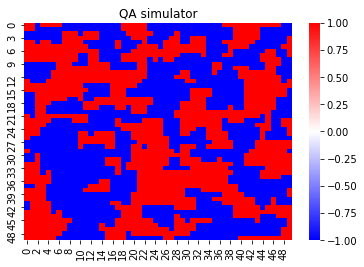

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
heatmap_qa = sigma_qa.reshape(L, L)
sns.heatmap(heatmap_qa, cmap = 'bwr')
plt.title('QA simulator')

Text(0.5, 1.0, 'local control')

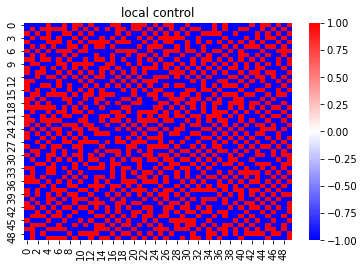

In [12]:
heatmap_local = sigma_local.reshape(L, L)
sns.heatmap(heatmap_local, cmap = 'bwr')
plt.title('local control')

Text(0.5, 1.0, 'QA simulator')

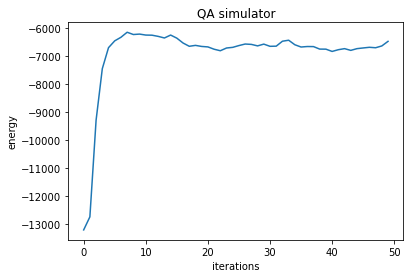

In [15]:
plt.plot(energy)
plt.xlabel('iterations')
plt.ylabel('energy')
plt.title('QA simulator')

# function tester

## A (neignborhood intersections)
if $L = 4$, the map becomes

|<!-- -->||||
|--|--|--|--|
|1|2|3|4|
|5|6|7|8|
|9|10|11|12|
|13|14|15|16|

- $1$st intersection has the neighbor of 2 and 5
- $2$nd - 1, 3, 6
- $10$th - 6, 9, 11, 14